## Runge Kutta 4th order for a comet in the solar system

Initial conditions

\begin{equation}
    \begin{cases}
    x_0 = & 4\times10^9 \text{km} \approx 26.73\text{UA}\\
    y_0 = & 0 \\
    z_0 = & 0 \\
    \end{cases}
\end{equation}

\begin{equation}
    \begin{cases}
    v_{x0} = & 0\\
    v_{y0} = & 500\frac{m}{s} \approx 0.105 \frac{km}{years} \\
    v_{z0} = & 0 \\
    \end{cases}
\end{equation}

In astronomical units (AU and years), the gravitational constant of the Sun is:
$$
GM = 4\pi^2 \, \text{AU}^3/\text{year}^2
$$

The specific energy (per unit mass) is:
$$
\mathcal{E} = \frac{v^2}{2} - \frac{GM}{r}
$$

$$
\mathcal{E} = \frac{(0.105)^2}{2} - \frac{4\pi^2}{26.73} \approx 0.0055 - 1.477 \approx -1.4715 \, \text{AU}^2/\text{year}^2
$$

Semi-major axis

The relationship between specific energy and semi-major axis is:
$$
a = -\frac{GM}{2\mathcal{E}} = -\frac{4\pi^2}{2(-1.4715)} \approx \frac{19.7392}{1.4715} \approx 13.41 \, \text{AU}
$$

Orbital period

Third law of Kepler:
$$
T^2 = a^3 \Rightarrow T = \sqrt{a^3} = \sqrt{13.41^3} \approx \sqrt{2409.8} \approx 49.08 \, \text{years}
$$

$$
\boxed{T \approx 49.08 \, \text{years}}
$$

For complete five orbits:
$$
49.08 \text{ years} \cdot 5 \approx 245 \text{ years}
$$

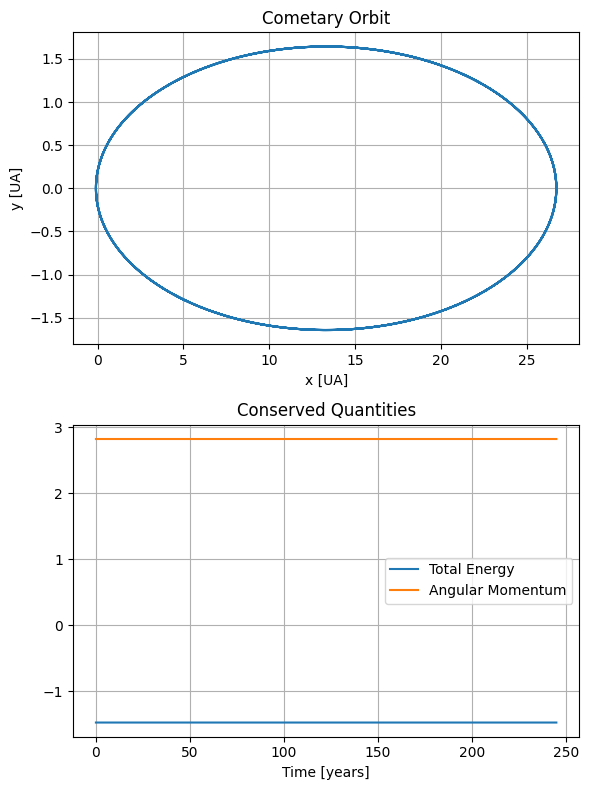

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit # Librery to compile Python code to machine code

G = 4 * np.pi**2   # AU^3 / year^2 * M_sun
M = 1              # M_sun 

# Sysmtem of ODEs
@njit # JIT compilation for performance
def ode(t, q0):
    f = np.zeros(6)
    f[0] = q0[3]  # vx
    f[1] = q0[4]  # vy
    f[2] = q0[5]  # vz
    r = np.sqrt(q0[0]**2 + q0[1]**2 + q0[2]**2)
    f[3] = -G * M * q0[0] / r**3
    f[4] = -G * M * q0[1] / r**3
    f[5] = -G * M * q0[2] / r**3
    return f

# Runge Kutta 4th order method
@njit
def RK4(f, t0, tf, q0, n):
    h = (tf - t0) / (n - 1)
    q = np.zeros((n, len(q0) + 1))
    q[0, 0] = t0
    q[0, 1:] = q0
    for i in range(n - 1):
        t = q[i, 0]
        y = q[i, 1:]
        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + h/2, y + k2/2)
        k4 = h * f(t + h, y + k3)
        q[i + 1, 0] = t + h
        q[i + 1, 1:] = y + (k1 + 2*k2 + 2*k3 + k4) / 6
    return q

# Conserved quantities of the system
@njit
def conserved_quantities(q):
    v2 = q[:,3]**2 + q[:,4]**2 + q[:,5]**2
    r = np.sqrt(q[:,0]**2 + q[:,1]**2 + q[:,2]**2)
    E = 0.5 * v2 - G * M / r           # Total energy
    Lx = q[:,1]*q[:,5] - q[:,2]*q[:,4]
    Ly = q[:,2]*q[:,3] - q[:,0]*q[:,5]
    Lz = q[:,0]*q[:,4] - q[:,1]*q[:,3]
    L = np.sqrt(Lx**2 + Ly**2 + Lz**2) # Angular momentum
    return E, L

# Initial conditions
x0 = 4e12 / 1.496e11                # 4e12 km to AU
vx0 = 0
y0 = 0
vy0 = (500 / 1.496e11) * 3.15576e7   # 500 m/s to UA/year
z0 = 0
vz0 = 0
q0 = np.array([x0, y0, z0, vx0, vy0, vz0])


t0 = 0         # Initial time in years
tf = 245       # Final time in years (400 years neccessary to complete 5 orbits)
n = 800000     # Number of steps

q = RK4(ode, t0, tf, q0, n)
E, L = conserved_quantities(q[:,1:])

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))

ax1.plot(q[:,1], q[:,2])
ax1.set_xlabel('x [UA]')
ax1.set_ylabel('y [UA]')
ax1.set_title('Cometary Orbit')
ax1.grid()

ax2.plot(q[:,0], E, label='Total Energy')
ax2.plot(q[:,0], L, label='Angular Momentum')
ax2.set_xlabel('Time [years]')
ax2.set_title('Conserved Quantities')
ax2.legend()
ax2.grid()

plt.tight_layout()
plt.show()

In [10]:
change_energy = E[n-1]  - E[0]
change_momentum = L[n-1] - L[0]    
print(f'The total change in total energy using RK4 is: {change_energy}')      
print(f'The total change in angular momentum using RK4 is {change_momentum}')

The total change in total energy using RK4 is: -9.23489140096656e-05
The total change in angular momentum using RK4 is -2.5776803358468214e-07


---
## Formula RK 3/4 with error estimation

Now we will present a scheme for the RK of order 3/4 (Bogaki and Shampine), whose fundamental equations will be

\begin{equation}
\begin{aligned}
k_1 &= \Delta x f(x_n, y_n)\,\,,\\
k_2 &= \Delta x f(x_n + \frac{1}{2} \Delta x, y_n + \frac{1}{2} k_1)\,\,,\\
k_3 &= \Delta x f(x_n + \frac{3}{4} \Delta x, y_n + \frac{3}{4} k_2)\,\,,\\
y_{n+1} &= y_n + \frac{2}{9} k_1 + \frac{1}{3} k_2 + \frac{4}{9} k_3 + \mathcal{O}(\Delta x^ 4)\,\,\\
k_4 &= \Delta x f(x_n + \Delta x, y_{n+1})\,\,\\
y^*_{n+1} &= y_n + \frac{7}{24} k_1 + \frac{1}{4}k_2 + \frac{1}{3}k_3 + \frac{1}{8 } k_4 + \mathcal{O}(\Delta x^5)\,\,.
\end{aligned}
\end{equation}

Note that in this scheme, the function $k_4$ of the step $n$ is equal to the function $k_1$ of the step $n+1$. Therefore, it is not necessary to evaluate $k_1$ again at step $n+1$; the computed value of $k_4$ is simply reserved and re-used in the next step. This trick is called **FSAL (First Same As Last)**.

The error in each of the integration steps is measured by comparing the result obtained by the RK3 method with the result obtained by the RK4 method,

\begin{equation}
\delta y_{n+1} = y_{n+1} - y^*_{n+1}\,\,.
\end{equation}

This estimated error is now required to remain smaller than the tolerance value, $|\delta y_{n+1}| \le \epsilon$ and for this the value of $\Delta x$ will be adjusted.


A given tolerance is usually used in the form

\begin{equation}
\epsilon = \epsilon_a + |y_{n+1}|\epsilon_r
\end{equation}

where

$\epsilon_a$ : absolute error tolerance

$\epsilon_r$ : relative error tolerance

### Step setting $\Delta x$

To adjust the size of the step, define the amount

\begin{equation}
\Theta = \frac{|\delta y_{n+1}|}{\epsilon}\,\,,
\end{equation}

and $\Theta_\text{desired} \approx 1$ is required.

If you have an algorithm with $\Theta \sim \mathcal{O}(\Delta x^p)$, you can adjust the value of $\Theta$ by modifying the step $\Delta x$ in the form

\begin{equation}
\Delta x_\text{desired} = \Delta x \left|\frac{\Theta_\text{desired}}{\Theta} \right| ^\frac{1}{p}\,\,,
\end{equation}

will return a value of $\Theta_\text{desired} = 1$.

---

Thus, a general form of the algorithm to fit $\Delta x$ is as follows:

1. Consider a step $\Delta x$ and calculate the value of $\Theta$.
2. If $\Theta > 1$ (very large error), then

  - define $\Delta x_\text{new} = \Delta x \left| \frac{1}{\Theta} \right|^{\frac{1}{p}} S$, where $S$ is a smoothing factor ($\sim$ $0.9$ ).
  
  - **Discard** the previous iteration and repeat it with $\Delta x_\mathrm{new}$.
  
3. If $\Theta < 1$ (very small error), then

  - define $\Delta x_\text{new} = \Delta x \left| \frac{1}{\Theta} \right|^{\frac{1}{p}} S$.
  
  - **Accept** the previous iteration and perform the next iteration with $\Delta x_\text{new}$.

  # Reference

The method of solving ODEs using Runge-Kutta methods is explained in detail in the repository by ashcat2005 on GitHub. You can find the relevant notebook [here](https://github.com/ashcat2005/ComputationalAstrophysics/blob/main/02.%20ODEs%20I.%20Euler%20and%20RK/01.%20ODE01.ipynb).


The number of steps taken is 5357


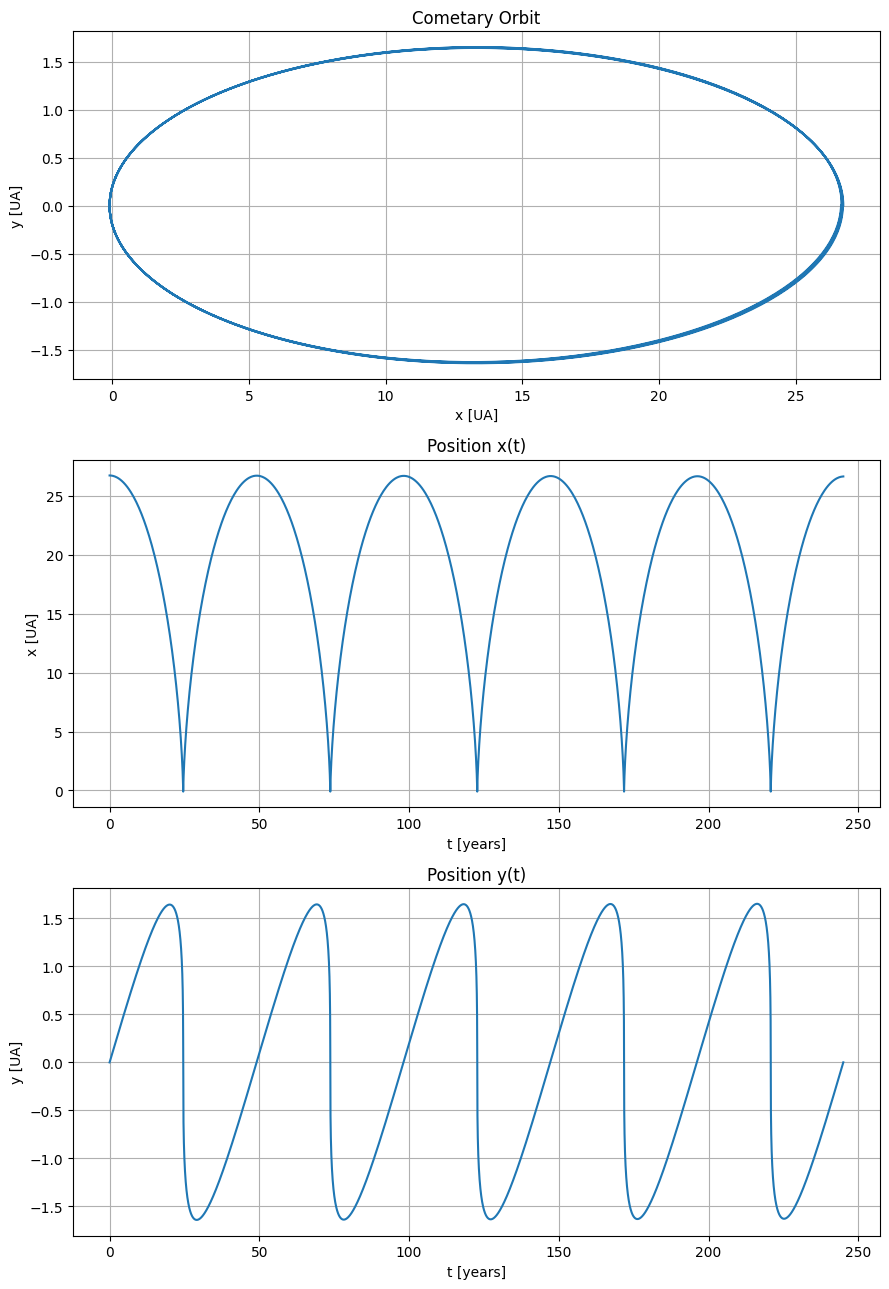

In [2]:
import numpy as np
import matplotlib.pyplot as plt

G = 4 * np.pi**2   # AU^3 / (yr^2 * M)]
M = 1  


def ode(t, q):
    f = np.zeros(6)
    f[0] = q[3]  # vx
    f[1] = q[4]  # vy
    f[2] = q[5]  # vz
    r = np.sqrt(q[0]**2 + q[1]**2 + q[2]**2)
    f[3] = -G * M * q[0] / r**3
    f[4] = -G * M * q[1] / r**3
    f[5] = -G * M * q[2] / r**3
    return f

# Bogacki-Shampine 3/4 method with adaptive step size
def rk34_adaptative(f, t0, tf, y0, h0=1e-2, tol_abs=1e-8, tol_rel=1e-6):
    S = 0.9
    h_min = 1e-10
    t = t0
    y = y0.copy()
    h = h0

    t_list = [t]
    y_list = [y.copy()]
    h_list = [h]

    while t < tf:
        if t + h > tf:
            h = tf - t  

        k1 = h * f(t, y)
        k2 = h * f(t + h/2, y + k1/2)
        k3 = h * f(t + 3*h/4, y + 3*k2/4)
        y_rk3 = y + (2/9)*k1 + (1/3)*k2 + (4/9)*k3

        k4 = h * f(t + h, y_rk3)
        y_rk4 = y + (7/24)*k1 + (1/4)*k2 + (1/3)*k3 + (1/8)*k4

        delta = y_rk4 - y_rk3
        epsilon = tol_abs + np.abs(y_rk4) * tol_rel
        theta = np.linalg.norm(delta / epsilon)

        if theta <= 1:
            t += h
            y = y_rk4.copy()
            t_list.append(t)
            y_list.append(y.copy())
            h_list.append(h)

        
        if theta == 0:
            h_new = h * 2
        else:
            h_new = h * min(5, max(0.1, S * theta**(-1/4)))

        h = max(h_min, h_new)

    return np.array(t_list), np.array(y_list), np.array(h_list)

# Initial conditions
x0 = 4e12 / 1.496e11                # 26.7383 UA
vx0 = 0
y0 = 0
vy0 = (500 / 1.496e11) * 3.15576e7  # 0.10535 UA/yr
z0 = 0
vz0 = 0
q0 = np.array([x0, y0, z0, vx0, vy0, vz0])


t0 = 0
tf = 245  # 245 years to complete 5 orbits

t_vals, y_vals, h_vals = rk34_adaptative(ode, t0, tf, q0, h0=1e-2, tol_abs=1e-8, tol_rel=1e-6)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(9, 13))

print(f'The number of steps taken is {len(t_vals)}')

# Plot the orbit in the xy-plane
ax1.plot(y_vals[:, 0], y_vals[:, 1])
ax1.set_xlabel('x [UA]')
ax1.set_ylabel('y [UA]')
ax1.set_title('Cometary Orbit')
ax1.grid()

# Plot the position x of the comet over time
ax2.plot(t_vals, y_vals[:, 0])
ax2.set_xlabel('t [years]')
ax2.set_ylabel('x [UA]')
ax2.set_title('Position x(t)')
ax2.grid()

# Plot the position y of the comet over time
ax3.plot(t_vals, y_vals[:,1])
ax3.set_xlabel('t [years]')
ax3.set_ylabel('y [UA]')
ax3.set_title('Position y(t)')
ax3.grid()

plt.tight_layout()
plt.show()


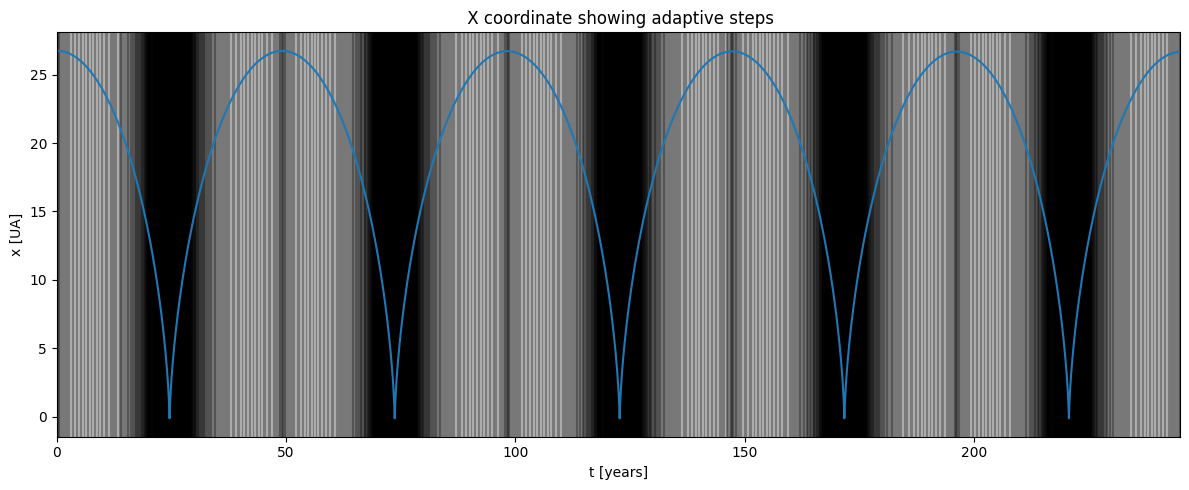

In [3]:
# Plot the step size h over time
h_norm = (h_vals - np.min(h_vals)) / (np.max(h_vals) - np.min(h_vals))
colors = 1 - h_norm  

fig, ax = plt.subplots(figsize=(12, 5))

for i in range(len(t_vals)):
    plt.axvline(t_vals[i], color= 'black', alpha=0.3)

# Dibujar x(t) encima
plt.plot(t_vals, y_vals[:, 0])

plt.xlabel(r't [years]')
plt.xlim(t0, tf)
plt.ylabel(r'x [UA]')
plt.title(r' X coordinate showing adaptive steps')
plt.tight_layout()
plt.show()

It can be seen that the adaptive method is faster than the fourth-order Runge-Kutta, even using the numba library to minimize the compilation time, the adaptive step method uses almost 1% of the number of steps, obtaining very good results.